In [60]:
import seaborn as sns
from seaborn import FacetGrid
import pandas as pd
import matplotlib.pyplot as plt
import os

df = None

# Get list of files in directory
files = os.listdir('data/images/cropped')

def convert_to_dataframe(files):
    # Create empty dict
    file_dict = {}

    # Loop through the files
    for file in files:
        # Split the filenames
        parts = file.split('_')
        if parts[0] == 'image':
            video_id = parts[1]
            timestamp = parts[2] + "_" + parts[3]
            # Create a key for the dictionary using the video_id and timestamp
            key = f"{video_id}_{timestamp}"
            # If the key doesn't exist in the dictionary, create a new list for it
            if key not in file_dict:
                file_dict[key] = []
            # Append the file path to the list of file paths for this key
            file_dict[key].append(os.path.join('data/images/cropped', file))

    # Convert to Pandas dataframe
    rows = []
    for key, value in file_dict.items():
        video_id = key.split("_")[0]
        timestamp = key.split("_")[1] + "_" + key.split("_")[2]
        count = len(value)
        rows.append((video_id, timestamp, count))

    df = pd.DataFrame(rows, columns=["video_id", "timestamp", "count"])
    df['timestamp']=pd.to_datetime(df['timestamp'],format='%Y-%m-%d_%H-%M-%S')
    df['day'] = df['timestamp'].dt.date
    df['hour'] = df['timestamp'].dt.hour
    
    return df
    
df = convert_to_dataframe(files)

def plot_timeseries(df):
    # Group the dataframe by day and create a dictionary of dataframes
    dfs = {day: group for day, group in df.groupby('day')}

    # Print the resulting dataframes
    for day, df in dfs.items():
        print(f"Dataframe for {day}:")
        print(df)
        
    # Group the data by video_id and timestamp, and calculate the count for each group
    df_plot = df.groupby(['video_id', 'timestamp'])['count'].sum().reset_index()

    # Use seaborn to create a timeseries plot with timestamp in the x-axis and count in the y-axis
    sns.set_style("darkgrid")
    sns.lineplot(x="timestamp", y="count", hue="video_id", data=df_plot)


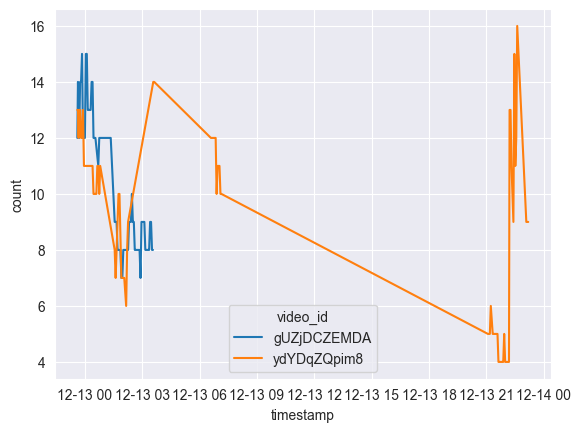

In [61]:
plot_timeseries(df)

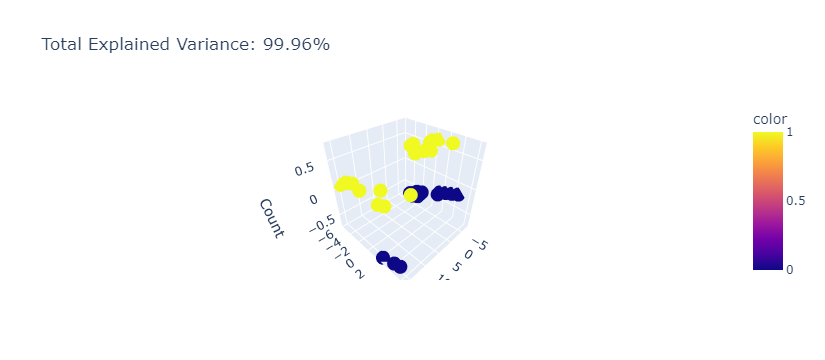

In [59]:
import numpy
import pandas as pd
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder


# Extract the time and day from the timestamp
df['hour'] = df['timestamp'].apply(lambda x: x.hour)
df['day'] = df['timestamp'].apply(lambda x: x.day)

# PCA can only accept numeric values, so convert species names to unique numbers
encoder = LabelEncoder()
encoder.fit(df['video_id'])
species_encoded = encoder.transform(df['video_id'])
df['id_encoded'] = species_encoded

# Select the columns for the PCA analysis
X = df[['hour', 'day', 'count', 'id_encoded']]
X = X.dropna()

# Initialize the PCA object with 3 components
pca = PCA(n_components=3)

# Fit the PCA model to the data and transform it
components = pca.fit_transform(X)

# Calculate the total explained variance
total_var = pca.explained_variance_ratio_.sum() * 100

# Create a 3D scatter plot using plotly express
fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=X['id_encoded'],
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'Hour', '1': 'Day', '2': 'Count', 'color': "Site"}
)

# Display the plot
fig.show()
